# Generating MNIST adversarial examples with AdvDCGAN

In [ ]:
!pip install git+https://github.com/tensorflow/docs
!pip install git+https://github.com/tensorflow/examples.git

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow_examples.models.dcgan import dcgan

from losses import carlini_wagner_loss_fn, l2_norm_soft_hinge_loss_fn
from models.advgan import AdvGAN
from models.target import MNISTConvTarget
from util import images_to_gif

In [3]:
IMAGES_DIR = 'images'
WEIGHTS_DIR = 'weights'

BASE_FILENAME = 'advdcgan_mnist'

In [4]:
import os

if not os.path.isdir(IMAGES_DIR):
    os.makedirs(IMAGES_DIR)

if not os.path.isdir(WEIGHTS_DIR):
    os.makedirs(WEIGHTS_DIR)

In [5]:
TARGET_LABEL = 3  # the chosen label for the targeted attack

BUFFER_SIZE = 60000
BATCH_SIZE = 256

INPUT_SHAPE = (28, 28, 1)

LATENT_DIM = 100

## Data loading and preprocessing

Load the MNIST training set images:

In [6]:
(images, labels), (_, _) = tf.keras.datasets.mnist.load_data()
images.shape

(60000, 28, 28)

Reshape the images to $28 \times 28 \times 1$ and normalize them to $[-1, 1]$:

In [7]:
images = images.reshape(images.shape[0], *INPUT_SHAPE).astype('float32')
images = (images - 127.5) / 127.5
images.shape

(60000, 28, 28, 1)

Remove the training set images that belong to the chosen target label:

In [8]:
target_filter = (labels != TARGET_LABEL)

images, labels = images[target_filter], labels[target_filter]
images.shape

(53869, 28, 28, 1)

Shuffle and batch the training set data:

In [9]:
dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## AdvDCGAN

AdvDCGAN is a [DCGAN](https://arxiv.org/abs/1511.06434)-based model for creating adversarial examples.

It consists of three parts: the generator, the discriminator, and the target of the adversarial attacks.

The generator creates the adversarial perturbations from random noise vectors, while the discriminator tries to distinguish between the original images and the adversarial images.

The target network is used for computing the adversarial loss, which guides the generator during training towards creating more successful adversarial images.

### Generator

The generator receives a random noise vector as input and shapes it into an adversarial perturbation of the desired size ($28 \times 28 \times 1$ for MNIST) using upsampling layers (`tf.keras.layers.Conv2DTranspose`).

Import the model from the [DCGAN](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/dcgan/dcgan.py) implementation in the installed [tensorflow_examples](https://github.com/tensorflow/examples) package:

In [10]:
generator = dcgan.make_generator_model()

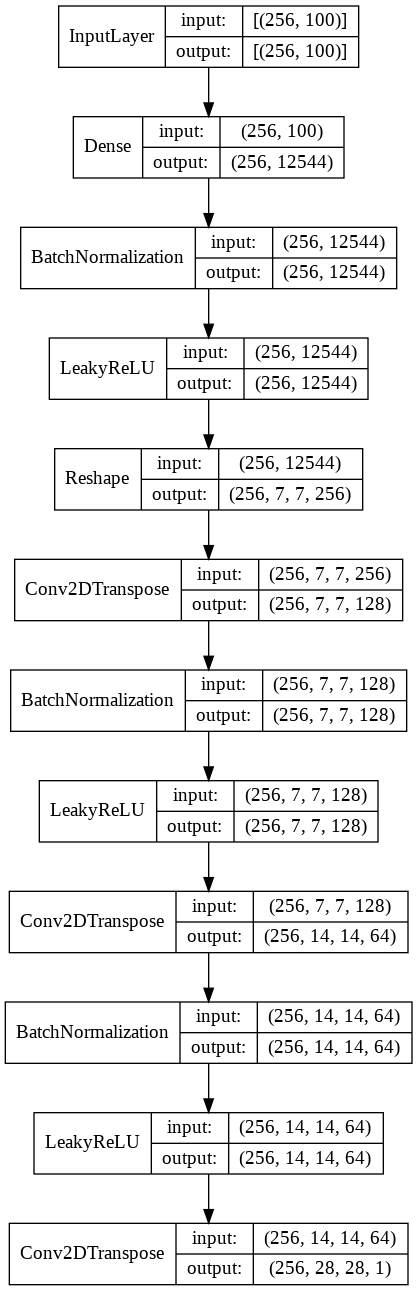

In [11]:
generator.build((BATCH_SIZE, LATENT_DIM))
tf.keras.utils.plot_model(generator, show_shapes=True, show_layer_names=False)

### Discriminator

The discriminator is a CNN-based binary classifier whose task is to differentiate between real images (from the training set) and adversarial images (created by the generator).

Import the model from the [DCGAN](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/dcgan/dcgan.py) implementation in the installed [tensorflow_examples](https://github.com/tensorflow/examples) package:

In [12]:
discriminator = dcgan.make_discriminator_model()

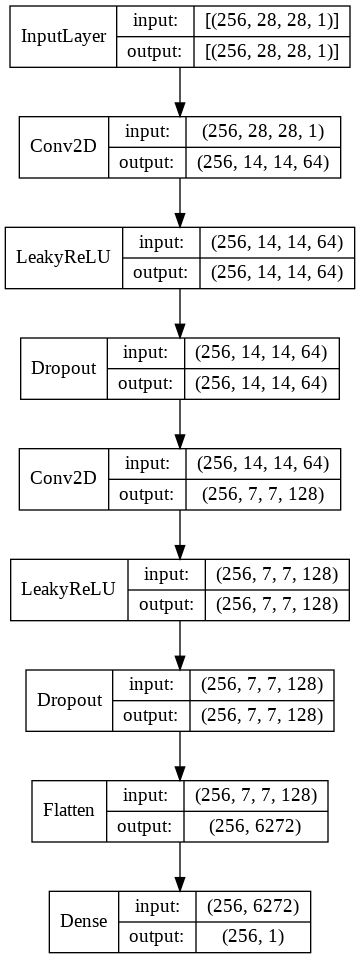

In [13]:
discriminator.build((BATCH_SIZE, *INPUT_SHAPE))
tf.keras.utils.plot_model(discriminator, show_shapes=True, show_layer_names=False)

### Target

The pre-trained `MNISTConvTarget` model is the target of the attacks.
It is used for computing the adversarial loss, which guides the generator during training.

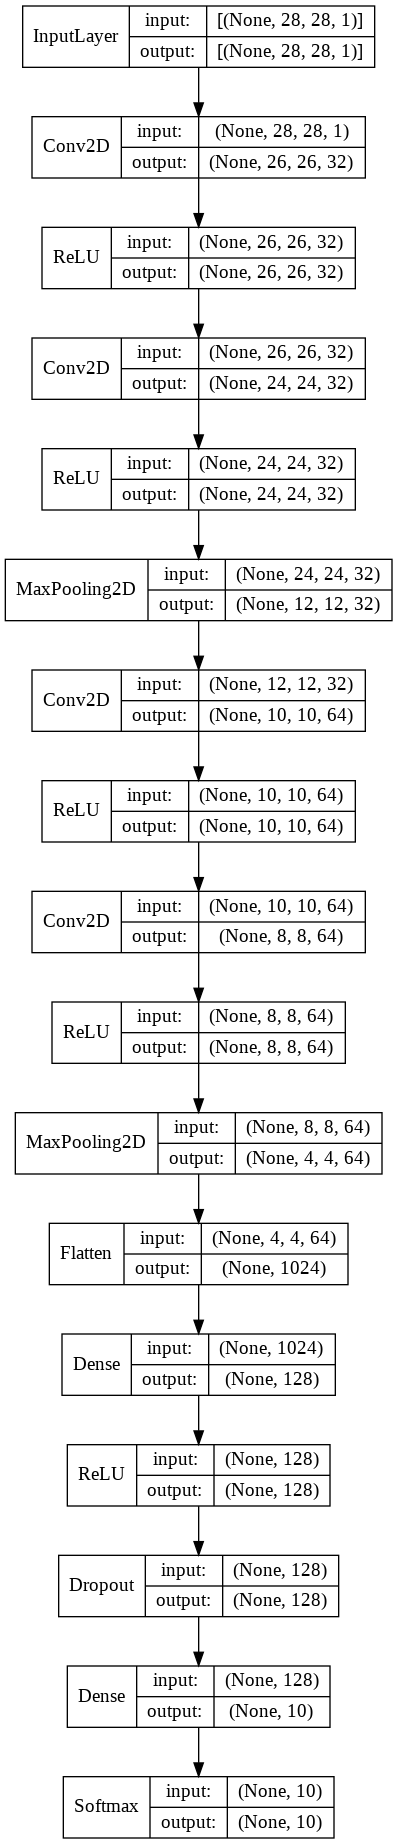

In [14]:
target = MNISTConvTarget()
tf.keras.utils.plot_model(target.model, show_shapes=True, show_layer_names=False)

In [15]:
weights_path = f'{WEIGHTS_DIR}/mnist_conv_target_20220106120545.h5'

target.built = True
target.load_weights(weights_path)

### Training

In each training step, the generator receives a batch of random noise vectors $\mathbf{z}$ as input and uses it to generate a batch of adversarial perturbations $G(\mathbf{z})$.

The adversarial images are obtained by combining the training set images with the perturbations: $\mathbf{x}_{adv} = \mathbf{x} + G(\mathbf{z})$ (making sure that the values remain in $[-1, 1]$).

The target model classifies the adversarial images, and the resulting class probabilities $f(\mathbf{x}_{adv})$ are used for calculating the adversarial loss.

Then, the discriminator classifies the real images (from the training set) and adversarial images (produced by the generator).

The loss is calculated for the discriminator and the generator respectively, and the resulting gradients are used to update them.

#### Discriminator loss

The discriminator's loss quantifies how well it distinguishes between real images $\mathbf{x}$ and generated images $\mathbf{x} + G(\mathbf{z})$.
As such, it is a sum of the losses computed on the real and fake outputs, respectively:

$\mathcal{L}_D = \mathcal{L_{D,\mathrm{real}}} + \mathcal{L_{D,\mathrm{fake}}}$

For the real component, the discriminator's predictions are compared to an array of 1s, and for the fake outputs to an array of 0s:

$\mathcal{L_{D,\mathrm{real}}} = BCE(\mathbf{1}, D(\mathbf{x}))$

$\mathcal{L_{D,\mathrm{fake}}} = BCE(\mathbf{0}, D(\mathbf{x} + G(\mathbf{z})))$,

where $BCE$ stands for the binary cross-entropy loss function.

#### Generator loss

In the adversarial attack setting, the generator loss $\mathcal{L}_G$, besides quantifying how well the generator fools the discriminator, also needs to quantify the successfulness of the generated adversarial images (i.e. how well do they fool the target into classifying them as the desired target label $t$).

The adversarial component of the loss is calculated according to the formula found in [Carlini and Wagner (2017b)](https://nicholas.carlini.com/papers/2017_sp_nnrobustattacks.pdf).
For a single adversarial image $x_{adv}$ and the corresponding class probabilities obtained from the target model $f(x_{adv})$, the adversarial loss is calculated as:

$\mathcal{L_{x_{adv}}} = \mathrm{max}(\mathrm{max}_{i \ne t} f(x_{adv})_i - f(x_{adv})_t,\ 0)$

Since we are training on batches of data, the final adversarial loss $\mathcal{L_{adv}}$ is a sum of all the individual adversarial losses for the adversarial images generated in the batch.

Additionally, a soft hinge loss on the L2 norm of the perturbations is added to bound their magnitude. For a single adversarial perturbation:

$\mathcal{L}_{perturb, z} = \mathrm{max}(||G(z)||_2 - \mathrm{bound}, 0)$,

where $\mathrm{bound}$ is a user-specified parameter (e.g. $0.3$).
Again, because we are dealing with batched data, the final perturbation loss $\mathcal{L}_{perturb}$ is a mean of all the individual perturbation losses for the batch.

The total generator loss is then:

$\mathcal{L}_G = \mathcal{L_{adv}} + \lambda_{gan}BCE(\mathbf{1}, D(\mathbf{x} + G(\mathbf{z}))) + \lambda_{perturb}\mathcal{L}_{perturb}$,

where $\lambda_{gan}$ and $\lambda_{perturb}$ are user-defined parameters that control the importance of the original generator loss and perturbation loss respectively.

Create the AdvDCGAN model:

In [16]:
advdcgan = AdvGAN(
    target=target,
    discriminator=discriminator,
    generator=generator,
    latent_dim=LATENT_DIM
)

Compile the model by adding the respective optimizers (two are needed because the discriminator and generator train separately), the base loss function, the adversarial loss function, the $\lambda$ parameters, and the optional $L_∞$ perturbation bound.

Note that `from_logits` needs to be set to `True` as the discriminator outputs logits instead of probabilities.

In [17]:
PERTURB_BOUND = None

advdcgan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    adv_loss_fn=carlini_wagner_loss_fn(target_label=TARGET_LABEL),
    perturb_loss_fn=l2_norm_soft_hinge_loss_fn(bound=0.3),
    lambda_gan=1,
    lambda_perturb=0.5,
    perturb_bound=PERTURB_BOUND
)

Create a callback that periodically saves generated images:

In [18]:
class AdvDCGANMonitor(tf.keras.callbacks.Callback):
    """
    A callback for creating and saving a specified number of adversarial images
    after each epoch.
    """

    def __init__(self, real_images, num_images, latent_dim, path_prefix, perturb_bound=None):
        """
        Inits the `AdvDCGANMonitor.
        
        :param real_images: a sample of real images
        :param num_images: the number of images to create
        :param latent_dim: size of the latent space vector (for DCGAN-based generators)
        :param path_prefix: prefix of the path at which to save the images
        :param perturb_bound: L-infinity norm of the perturbations
        """
        super().__init__()

        self.real_images = real_images
        self.num_images = num_images
        self.path_prefix = path_prefix
        self.noise = tf.random.normal(shape=(num_images, latent_dim))
        self.perturb_bound = perturb_bound

    def on_epoch_end(self, epoch, logs=None):
        _, ax = plt.subplots(self.num_images, 3, figsize=(8, 8))

        perturbations = self.model.generator(self.noise, training=False)
        
        for i, real_image in enumerate(self.real_images):
            real_image = real_image[0, :, :, 0]
            perturbation = perturbations[i, :, :, 0]

            if self.perturb_bound:
                perturbation = tf.clip_by_value(
                    perturbation, -self.perturb_bound, self.perturb_bound)
                
            adv_image = tf.clip_by_value(real_image + perturbation, -1, 1)

            ax[i, 0].imshow(real_image * 127.5 + 127.5, cmap='gray', vmin=0, vmax=255)
            ax[i, 1].imshow(perturbation * 127.5 + 127.5, cmap='gray', vmin=0, vmax=255)
            ax[i, 2].imshow(adv_image * 127.5 + 127.5, cmap='gray', vmin=0, vmax=255)

            ax[i, 0].set_title('real image')
            ax[i, 1].set_title('perturbation')
            ax[i, 2].set_title('adversarial image')

            ax[i, 0].axis('off')
            ax[i, 1].axis('off')
            ax[i, 2].axis('off')

        plt.tight_layout()
        plt.savefig(f'{self.path_prefix}_{epoch + 1:03d}.png')
        plt.close()


In [19]:
NUM_IMAGES = 5

monitor = AdvDCGANMonitor(
    real_images=tf.data.Dataset.from_tensor_slices(images).batch(1).take(NUM_IMAGES),
    num_images=NUM_IMAGES,
    latent_dim=LATENT_DIM,
    path_prefix=f'{IMAGES_DIR}/{BASE_FILENAME}',
    perturb_bound=PERTURB_BOUND
)

Finally, train the model:

In [20]:
history = advdcgan.fit(
    dataset,
    epochs=50,
    callbacks=[monitor]
)

Epoch 1/50
211/211 [==============================] - 19s 67ms/step - d_loss: 0.0480 - g_loss: 39.7779 - g_gan_loss: 6.6596 - g_adv_loss: 31.3066 - g_perturb_loss: 3.6236
Epoch 2/50
211/211 [==============================] - 14s 67ms/step - d_loss: 0.0054 - g_loss: 12.4275 - g_gan_loss: 6.9310 - g_adv_loss: 3.6366 - g_perturb_loss: 3.7196
Epoch 3/50
211/211 [==============================] - 14s 68ms/step - d_loss: 0.0035 - g_loss: 11.8262 - g_gan_loss: 7.6617 - g_adv_loss: 2.2671 - g_perturb_loss: 3.7949
Epoch 4/50
211/211 [==============================] - 14s 67ms/step - d_loss: 0.0045 - g_loss: 13.5386 - g_gan_loss: 8.4263 - g_adv_loss: 3.1561 - g_perturb_loss: 3.9124
Epoch 5/50
211/211 [==============================] - 14s 68ms/step - d_loss: 0.0076 - g_loss: 13.9956 - g_gan_loss: 8.6593 - g_adv_loss: 3.3692 - g_perturb_loss: 3.9343
Epoch 6/50
211/211 [==============================] - 14s 68ms/step - d_loss: 0.0053 - g_loss: 14.5763 - g_gan_loss: 9.3520 - g_adv_loss: 3.2157 - g_

In [21]:
import time

weights_path = f'{WEIGHTS_DIR}/{BASE_FILENAME}_{time.strftime("%Y%m%d%H%M%S")}.h5'
advdcgan.save_weights(weights_path)

Plot the generator and discriminator losses through the epochs:

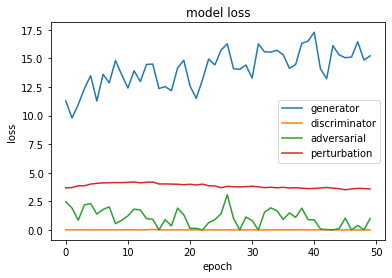

In [22]:
plt.plot(history.history['g_loss'])
plt.plot(history.history['d_loss'])
plt.plot(history.history['g_adv_loss'])
plt.plot(history.history['g_perturb_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['generator', 'discriminator', 'adversarial', 'perturbation'], loc='best')

plt.show()

Plot the generator's progress through the epochs:


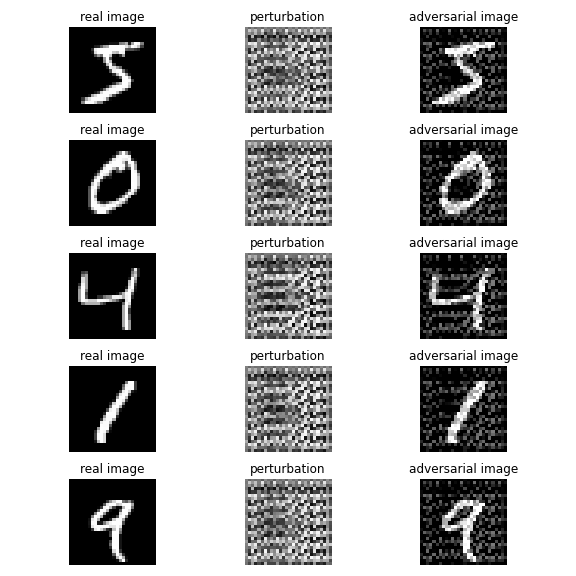

In [23]:
import tensorflow_docs.vis.embed as embed

image_pattern = f'{IMAGES_DIR}/{BASE_FILENAME}*.png'
gif_path = f'{IMAGES_DIR}/{BASE_FILENAME}.gif'

images_to_gif(image_pattern, gif_path, delete_frames=True)
embed.embed_file(gif_path)

### Classifying generated images using `MNISTConvTarget`

We'll test the generator's performance by classifying the adversarial images it creates using the `MNISTConvTarget` model.

Get a sample of images:

In [24]:
images_sample = tf.data.Dataset.from_tensor_slices(images).batch(1).take(NUM_IMAGES)

Generate and classify adversarial images obtained for the sample:

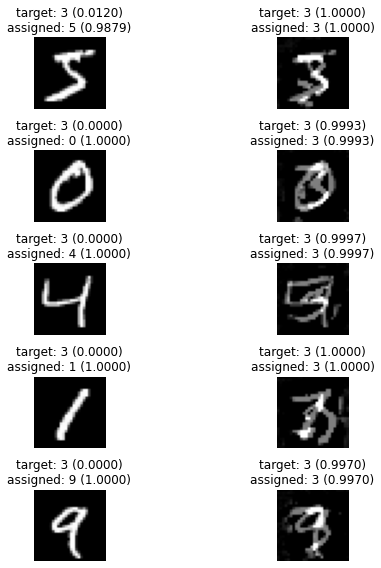

In [25]:
noise = tf.random.normal(shape=(NUM_IMAGES, LATENT_DIM))
perturbations = generator(noise, training=False)

_, ax = plt.subplots(NUM_IMAGES, 2, figsize=(8, 8))

for i, real_image in enumerate(images_sample):
    real_image = real_image[0, :, :, 0]
    perturbation = perturbations[i, :, :, 0]

    if PERTURB_BOUND:
        perturbation = tf.clip_by_value(
            perturbation, -PERTURB_BOUND, PERTURB_BOUND)
        
    adv_image = tf.clip_by_value(real_image + perturbation, -1, 1)

    for j, image in enumerate([real_image, adv_image]):
        probs = target.predict(image[tf.newaxis, :, :, tf.newaxis])
        max_label = probs.argmax()
        max_prob = probs.max()
        target_prob = probs[0][TARGET_LABEL]

        ax[i, j].imshow(image * 127.5 + 127.5, cmap='gray', vmin=0, vmax=255)
        ax[i, j].set_title(f'target: {TARGET_LABEL} ({target_prob:.4f})'
                           f'\nassigned: {max_label} ({max_prob:.4f})')
        ax[i, j].axis('off')

plt.tight_layout()
plt.show()